# Time Series Classification

## Import modules and set path.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


PATH='/Users/nicholashedger/Documents'

## Load in files.

Here I load the timeseries and labels into a pandas dataframe

In [2]:
def load_data(PATH,FILE):
	csvpath=os.path.join(PATH,FILE)
	return pd.read_csv(csvpath)


TIMESERIES=load_data(PATH,'timeseries.csv') # The full timeseries data.
SCRAMLAB=load_data(PATH,'sclabels.csv') # The labels corresponding to whether the trial was scrambled or not.
SIDETIMESERIES=load_data(PATH,'timeseriesside.csv') # The timeseries for intact images only
SIDELAB=load_data(PATH,'sidelabels.csv') # The labels corresponding to the location of the social image.

## Review data structure

In [3]:
TIMESERIES.shape

(3078000, 6)

In [4]:
SCRAMLAB.shape

(6156, 2)

In [5]:
SIDELAB.shape

(3080, 2)

The timeseries data has the following structure: There is the id (timeseries number) a timestamp and a corresponding X and Y value for each timestamp.

In [6]:
TIMESERIES.head()

,Unnamed: 0,id,time,X,Y,ps
0,1,1,0.00000,762.3,639.5,1
1,2,1,10.02004,762.3,639.5,1
2,3,1,20.04008,762.3,639.5,1
3,4,1,30.06012,762.3,639.5,1
4,5,1,40.08016,762.3,639.5,1


There are 6156 timeseries, each of which has a correspondig label in the SCRAMLAB dataframe.

In [11]:
len(np.unique(TIMESERIES["id"]))

6156

In [8]:
SCRAMLAB.head()

,Unnamed: 0,sc
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


SCRAMLAB and SIDELAB just code the labels to be classified (1 per timeseries). Plot an example timeseries instance.

In [231]:
# Plot a timeseries and add some bells and whistles. Plot where the stimuli are and a title indicating whether
# it was a scrambled or intact trial.
SCRAMLAB=SCRAMLAB.drop('Unnamed: 0',1)
def tsplot(FRAME,id):
    fig1, ax =plt.subplots(1)
    instance=FRAME[(FRAME["id"]==id)]
    plt.plot(instance['X'],instance['Y'])
    plt.axis([100,1500,300,900])
    rect=patches.Rectangle((168,378),544,444,facecolor='none',edgecolor='r') # Plot the grid area
    rect2=patches.Rectangle((888,378),544,444,facecolor='none',edgecolor='r')
    ax.add_patch(rect)
    ax.add_patch(rect2)
    num=SCRAMLAB.iloc[id-1,0] # Reference the timeseries with the label. 
    lab="Scram = %d" % (num)
    plt.title(lab)
    plt.show()

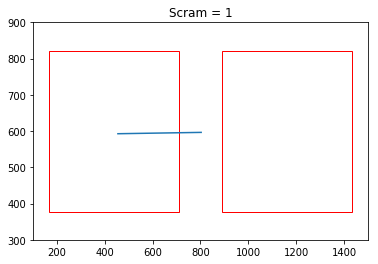

In [449]:
x=tsplot(TIMESERIES,1303) # Plot the Y coordinate for the first timeseries.


In [168]:
# Drop columns not required.
TIMESERIES=TIMESERIES.drop('Unnamed: 0',1)
SIDETIMESERIES=SIDETIMESERIES.drop('Unnamed: 0',1)
SCRAMLAB=SCRAMLAB.drop('Unnamed: 0',1)
SIDELAB=SIDELAB.drop('Unnamed: 0',1)
TIMESERIES=TIMESERIES.drop('ps',1)
SIDETIMESERIES=SIDETIMESERIES.drop('ps',1)

## Classifcation of intact versus scrambled images

Now we get the labels into a 1D format.

In [12]:
# Re-structure labels into a 1D numpy array
LABELS=SCRAMLAB
LABELSPREP=pd.DataFrame.as_matrix(LABELS)
LABELSPREP=np.squeeze(LABELSPREP)

In [13]:
LABELSPREP.shape

(6156,)

Now the data are all in the correct format, import the tsfresh module and ask it to engineer some features. The  [following features are calculated](http://tsfresh.readthedocs.io/en/latest/text/list_of_features.html)

In [14]:
from tsfresh import extract_relevant_features

/Users/nicholashedger/anaconda2/envs/env/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
features_filtered_direct = extract_relevant_features(TIMESERIES, LABELSPREP,
                                                     column_id='id', column_sort='time')

Feature Extraction: 10it [1:46:46, 640.69s/it]                       
 'X__friedrich_coefficients__m_3__r_30__coeff_1'
 'X__friedrich_coefficients__m_3__r_30__coeff_2'
 'X__friedrich_coefficients__m_3__r_30__coeff_3'
 'X__max_langevin_fixed_point__m_3__r_30'
 'Y__friedrich_coefficients__m_3__r_30__coeff_0'
 'Y__friedrich_coefficients__m_3__r_30__coeff_1'
 'Y__friedrich_coefficients__m_3__r_30__coeff_2'
 'Y__friedrich_coefficients__m_3__r_30__coeff_3'
 'Y__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.


In this next section I dumped the data into a pickle (commented out). Here I can load the pickle object.   

In [174]:
# Dump the data. 
#import dill                            
#filename = 'T_S_dump.pkl'
#dill.dump_session(filename)

import dill
PATH='/Users/nicholashedger/Documents'
dill.load_session(os.path.join(PATH,'T_S_dump.pkl'))


Inspect the structure of the extracted features. Its a pandas dataframe

In [173]:
features_filtered_direct.head()

variable,Y__approximate_entropy__m_2__r_0.1,X__number_cwt_peaks__n_1,Y__number_cwt_peaks__n_1,X__ratio_value_number_to_time_series_length,Y__ratio_value_number_to_time_series_length,X__sample_entropy,Y__approximate_entropy__m_2__r_0.3,Y__sum_of_reoccurring_values,X__variance,X__standard_deviation,...,"X__fft_coefficient__coeff_94__attr_""abs""","X__fft_coefficient__coeff_61__attr_""angle""",Y__ar_coefficient__k_10__coeff_3,"Y__fft_coefficient__coeff_43__attr_""angle""","Y__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""slope""","Y__linear_trend__attr_""slope""","Y__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""slope""","Y__fft_coefficient__coeff_71__attr_""abs""","Y__fft_coefficient__coeff_48__attr_""abs""","Y__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""slope"""
id,,,,,,,,,,,,,,,,,,,,,
1,0.069963,10.0,10.0,0.020,0.020,1.361701,0.061495,6583.2,82805.549340,287.759534,...,367.140301,108.696081,-6.217249e-15,125.899286,0.826633,0.165351,1.652533,60.895830,78.863978,8.252327
2,0.094173,13.0,13.0,0.026,0.024,1.279313,0.100075,7825.1,116950.871890,341.980806,...,538.242008,155.249563,2.331468e-15,137.776559,1.369600,0.273970,2.740423,367.013170,297.593404,13.848824
3,0.082168,9.0,9.0,0.018,0.018,0.949978,0.077263,5026.7,122986.538696,350.694367,...,910.329899,53.904862,-6.661338e-15,16.203437,-0.464989,-0.092977,-0.930203,86.116015,281.703577,-4.728473
4,0.114255,14.0,13.0,0.030,0.030,1.231056,0.105340,9163.8,74225.197703,272.443017,...,419.955742,-34.617118,8.301813e-03,131.015213,-0.425386,-0.085102,-0.850875,335.821742,835.838888,-4.331055
5,0.098275,13.0,13.0,0.026,0.026,1.129762,0.077954,8287.7,87283.405329,295.437650,...,1272.998796,-9.058874,-1.776357e-15,-158.461336,0.031612,0.006309,0.063588,118.916038,45.969206,0.225564


Order the features by their relevance and show the 10 most relevant

In [201]:
#from tsfresh.feature_selection.relevance import calculate_relevance_table
templab=pd.Series(LABELSPREP,index=np.unique(TIMESERIES["id"]))
templab.head()
templab.unique
sigtable=calculate_relevance_table(X=features_filtered_direct,y=templab)

In [413]:
sigtable.head(n=10)

,feature,type,p_value,relevant
feature,,,,
Y__approximate_entropy__m_2__r_0.1,Y__approximate_entropy__m_2__r_0.1,real,5.099619e-84,True
X__number_cwt_peaks__n_1,X__number_cwt_peaks__n_1,real,1.003600e-82,True
Y__number_cwt_peaks__n_1,Y__number_cwt_peaks__n_1,real,1.260592e-82,True
X__ratio_value_number_to_time_series_length,X__ratio_value_number_to_time_series_length,real,5.500069e-80,True
Y__ratio_value_number_to_time_series_length,Y__ratio_value_number_to_time_series_length,real,7.085686e-80,True
X__sample_entropy,X__sample_entropy,real,2.325208e-77,True
Y__approximate_entropy__m_2__r_0.3,Y__approximate_entropy__m_2__r_0.3,real,1.933456e-75,True
Y__sum_of_reoccurring_values,Y__sum_of_reoccurring_values,real,3.988942e-65,True
X__standard_deviation,X__standard_deviation,real,3.689166e-64,True


Define a function for showing the trials that represent the highest and lowest of a feature

In [417]:
def SHOWFEATURE(feature):
    fig, ax = plt.subplots(figsize=(20, 20))
    for i in range(4): # Plot the top 4 instances
        for j in range(2):
            ax = plt.subplot2grid((5,3), (i,j))
            if j==1: 
                league=features_filtered_direct.sort_values(by=[feature],ascending=True) # The lowest values
            else:
                league=features_filtered_direct.sort_values(by=[feature],ascending=False) # The highest values
            idt=league.iloc[[i]].index[0] # Get the id
            var=round(league[feature].iloc[i],3) # Get the value of the variable
            instance=TIMESERIES[(TIMESERIES["id"]==idt)] # Get the timeseries corresponding to the ID
            plt.axis([100,1500,300,900])
            rect=patches.Rectangle((168,378),544,444,facecolor='none',edgecolor='r') # Plot the grid area
            rect2=patches.Rectangle((888,378),544,444,facecolor='none',edgecolor='r')
            num=SCRAMLAB.iloc[idt-1,0] # Reference the timeseries with the label to determine whether it was scrambled or not
            ax.add_patch(rect)
            ax.add_patch(rect2)
            lab="ID= %d, var= %f Scram = %d" % (idt,var,num)
            ax.set_title(lab)
            ax.plot(instance['X'],instance['Y'])

Now plot the 4 trials that represent the highest and lowest of the most informative feature.

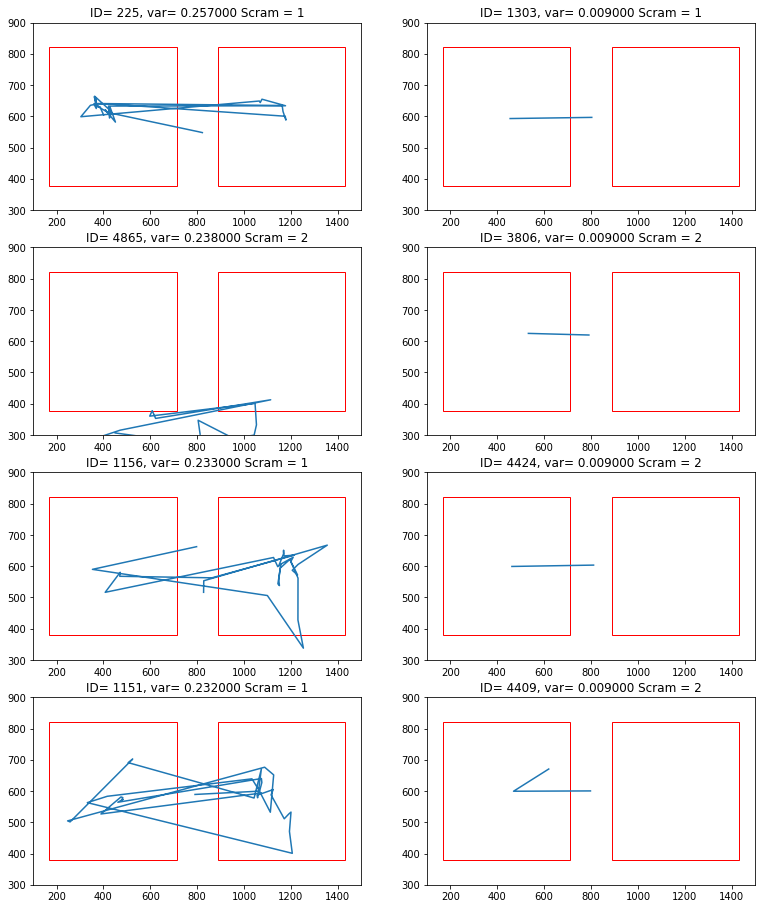

In [418]:
SHOWFEATURE('Y__approximate_entropy__m_2__r_0.1')

Now standardise the feature matrix

In [416]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trans=scaler.fit(features_filtered_direct)
scaled=scaler.transform(features_filtered_direct)
scaled.shape

(6156, 518)

Split the data into a training and test set.

In [419]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(scaled, LABELSPREP, test_size=.2)


Fit a random forest classifier to the training data.

In [422]:
from sklearn.ensemble import RandomForestClassifier
cl = RandomForestClassifier() 
cl.fit(X_train, y_train) # Fit to the training data

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Get the accuracy score for the training data.

In [428]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, cl.predict(X_train))

0.98862713241267264

Now perform cross-validation

In [429]:
scoreCV=cross_val_score(cl,X_train,y_train,cv=10,scoring='accuracy') # Cross validate.

scoreCV

array([ 0.70791075,  0.70993915,  0.72210953,  0.74239351,  0.67545639,
        0.67748479,  0.68762677,  0.68228106,  0.6700611 ,  0.6904277 ])

The model seems to be over-fitting. Also check the classification performance for the test data

In [425]:
from sklearn.metrics import classification_report # Show performance at classifying the test data
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.69      0.77      0.73       623
          2       0.73      0.65      0.69       609

avg / total       0.71      0.71      0.71      1232



Take a look at the features that ended up being the most important for the random forest classifier

In [431]:
attributes=list(features_filtered_direct)

sorted(zip(cl.feature_importances_,attributes),reverse=True)


[(0.027741626801288687, 'X__sample_entropy'),
 (0.014625673909551874,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_20'),
 (0.012631222238588008, 'X__binned_entropy__max_bins_10'),
 (0.012096177370603981, 'X__minimum'),
 (0.0120507352250286, 'Y__approximate_entropy__m_2__r_0.1'),
 (0.011389480405947904,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20'),
 (0.010264756271752332, 'Y__approximate_entropy__m_2__r_0.3'),
 (0.0099369810164935176,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_20'),
 (0.0095972417713900433,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20'),
 (0.008495763864670304,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10'),
 (0.0082664588117087705, 'X__number_cwt_peaks__n_1'),
 (0.0081991870502746873, 'X__quantile__q_0.4'),
 (0.0081096807395765868,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_20'),
 (0.0077665908553372033,
  'Y__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0'),
 (0.00

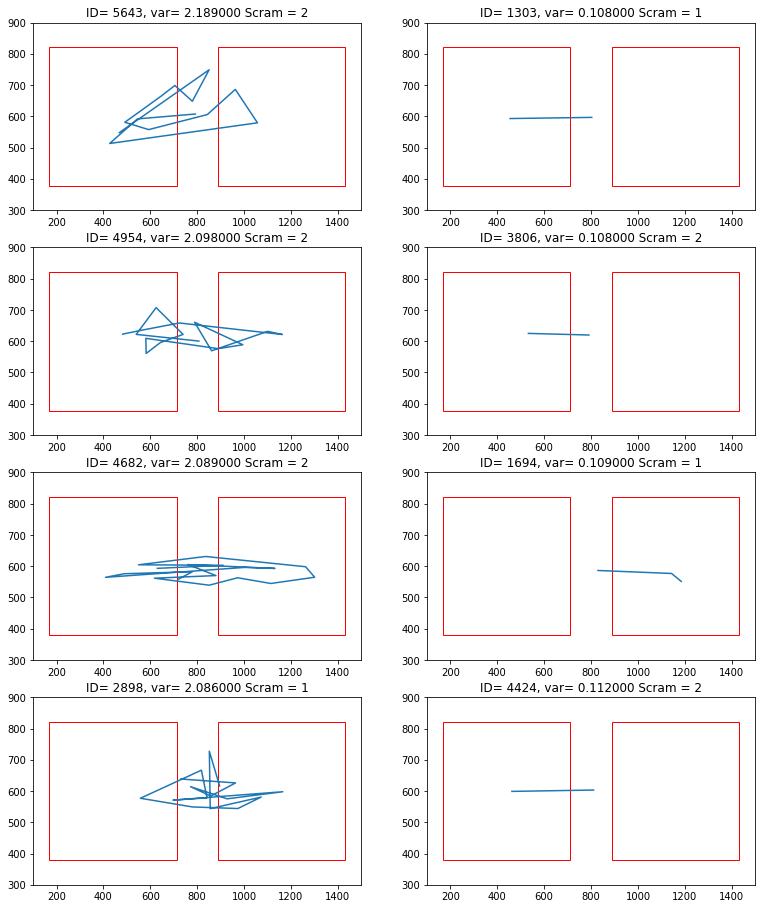

In [432]:
SHOWFEATURE('X__sample_entropy')

Since we were over-fitting create a new feature matrix using the top k features.

In [443]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


top_k=indices_of_top_k(cl.feature_importances_,40)

toplabels=np.array(attributes)[top_k]

topkmat=np.array(features_filtered_direct)[:,top_k]


X_train, X_test, y_train, y_test = train_test_split(topkmat, LABELSPREP, test_size=.2)

from sklearn.ensemble import RandomForestClassifier

cl2 = RandomForestClassifier()
cl2.fit(X_train, y_train)

scoreCV2=cross_val_score(cl2,X_train,y_train,cv=10,scoring='accuracy')


In [444]:
scoreCV2

array([ 0.71602434,  0.69776876,  0.74442191,  0.69776876,  0.72616633,
        0.69308943,  0.74186992,  0.70731707,  0.71138211,  0.74338086])

Perform a full grid search of hyper-parameters

In [445]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 15, 30], 'max_features': [5, 10, 20, 40],'max_depth': [10,15,20],'min_samples_leaf': [15,20,30],'warm_start':[True,False]}]


from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(cl2, param_grid, cv=5,scoring='accuracy')

grid_search.fit(X_train, y_train)


cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)


(0.70775792038992691, {'max_features': 5, 'n_estimators': 3, 'warm_start': True, 'max_depth': 10, 'min_samples_leaf': 15})
(0.70978878960194969, {'max_features': 5, 'n_estimators': 3, 'warm_start': False, 'max_depth': 10, 'min_samples_leaf': 15})
(0.73537774167343628, {'max_features': 5, 'n_estimators': 10, 'warm_start': True, 'max_depth': 10, 'min_samples_leaf': 15})
(0.73517465475223398, {'max_features': 5, 'n_estimators': 10, 'warm_start': False, 'max_depth': 10, 'min_samples_leaf': 15})
(0.73862713241267264, {'max_features': 5, 'n_estimators': 15, 'warm_start': True, 'max_depth': 10, 'min_samples_leaf': 15})
(0.73639317627944756, {'max_features': 5, 'n_estimators': 15, 'warm_start': False, 'max_depth': 10, 'min_samples_leaf': 15})
(0.7422826969943136, {'max_features': 5, 'n_estimators': 30, 'warm_start': True, 'max_depth': 10, 'min_samples_leaf': 15})
(0.74126726238830221, {'max_features': 5, 'n_estimators': 30, 'warm_start': False, 'max_depth': 10, 'min_samples_leaf': 15})
(0.7075

In [446]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [447]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          1       0.76      0.72      0.74       615
          2       0.74      0.77      0.75       617

avg / total       0.75      0.75      0.75      1232



In [441]:
grid_search.best_estimator_.feature_importances_

array([ 0.17328706,  0.17841559,  0.08012547,  0.10061255,  0.08574509,
        0.2472485 ,  0.02866103,  0.02381265,  0.03486071,  0.04723134])

In [ ]:
toplabels